## Triangulation! 

In [137]:
%matplotlib inline
import numpy
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, PathPatch
from matplotlib.path import Path
import math

# Lets generate some shapes

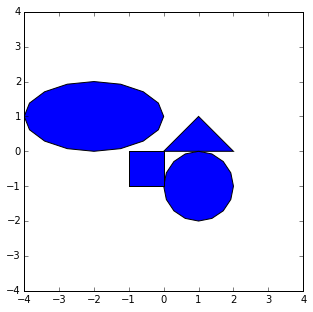

In [138]:
# Basic square and triangle
base_shapes = {'square': numpy.array([[0, 0], [0, 1], [1, 1], [1, 0]]),
               'triangle': numpy.array([[0, 0], [2, 0], [1, 1]])}

# Circle
num_circle_points = 16
radians_per_point = 2 * math.pi / num_circle_points
point_angles = [radians_per_point * i for i in range(num_circle_points)]
circle_x_coords = numpy.cos(point_angles)
circle_y_coords = numpy.sin(point_angles)

# Numpy magic:
# x/y arrays are a 1xN array, where N is the number of circle points
# Vstack them to make a 2xN array, of form [[x0, x1...xN], [y0, y1...yN]]
# transpose 
# leading to a nice [[x0, y0], [x1, y1]......[xN, yN]] array.
# Add one to move the center up to (1, 1)
base_shapes['circle'] = numpy.vstack((circle_x_coords, circle_y_coords)).transpose() + 1

# Oval
x_multiplier = 2.0
y_multiplier = 1.0
base_shapes['oval'] = numpy.copy(base_shapes['circle'])
base_shapes['oval'][:, 0] *= x_multiplier
base_shapes['oval'][:, 0] + 1
base_shapes['oval'][:, 1] *= y_multiplier

def plot_polygon(polygon, plot):
    plot.add_patch(Polygon(polygon))
    

fig = plt.figure(num=1, figsize=(5, 5), dpi=30)
ax = fig.add_subplot(111)
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_aspect(1.0)

for axis_offsets, shape_points in zip([[1, 1], [1, -1], [-1, -1], [-1, 1]], base_shapes.values()):    
    # Flip over the axes and plot
    ax.add_patch(Polygon(shape_points * axis_offsets))

plt.show()

# Simple Triangulation

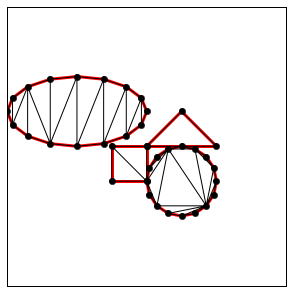

In [139]:
from triangle import triangulate, get_data, plot as tplot
from pprint import pprint

fig = plt.figure(num=2, figsize=(5, 5), dpi=30)
ax = fig.add_subplot(111)
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_aspect(1.0)

for axis_offsets, shape_points in zip([[1, 1], [1, -1], [-1, -1], [-1, 1]], base_shapes.values()):
    # Generate line segment array
    segments = numpy.array([[i, i + 1] for i in range(len(shape_points))])
    segments %= len(shape_points)
    
    triangulated = triangulate({'vertices': shape_points * axis_offsets,
                                'segments': segments}, 'p')
    
    tplot.plot(ax, **triangulated)

plt.show()

## Concave Shape

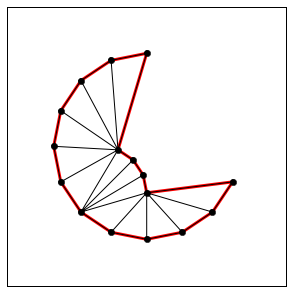

In [140]:
caved_in_circle = base_shapes['circle'].copy()

points_in_quarter = len(caved_in_circle) // 4

caved_in_circle[0:points_in_quarter] *= 0.5

fig = plt.figure(num=3, figsize=(5, 5), dpi=30)
ax = fig.add_subplot(111)

segments = numpy.array([[i, i + 1] for i in range(len(caved_in_circle))])
segments %= len(shape_points)

triangulated = triangulate({'vertices': caved_in_circle,
                            'segments': segments}, 'p')
    
tplot.plot(ax, **triangulated)

## Hole

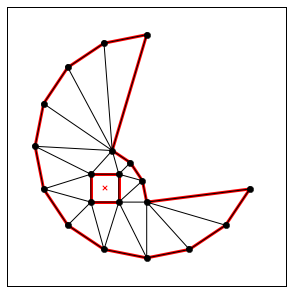

In [141]:
caved_in_circle_with_hole = caved_in_circle * 4

segments = numpy.array([[i, i + 1] for i in range(len(caved_in_circle_with_hole))])
segments %= len(caved_in_circle_with_hole)

# Add a square hole, with lover left corner at (2, 2)
square_hole = numpy.array([[0, 0], [0, 1], [1, 1], [1, 0]])
square_hole += [2, 2]

# Add the square line indices to the segement array.
segments = numpy.vstack((segments, numpy.array([[0, 1], [1, 2], [2, 3], [3, 0]]) + len(segments)))

# Add the square hole to the vertex array.
caved_in_circle_with_hole = numpy.vstack((caved_in_circle_with_hole, square_hole))

triangulated = triangulate({'vertices': caved_in_circle_with_hole,
                            'segments': segments,
                            'holes': [[2.5, 2.5]]}, 'p')

fig = plt.figure(num=4, figsize=(5, 5), dpi=30)
ax = fig.add_subplot(111)

tplot.plot(ax, **triangulated)

## Complex Hole (Constrained Delanuay)

Num triangles: 25


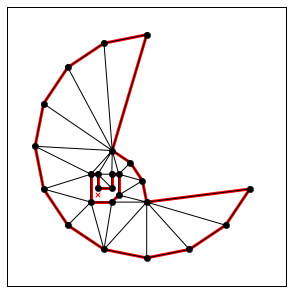

In [142]:
caved_in_circle_with_complex_hole = caved_in_circle * 4

segments = numpy.array([[i, i + 1] for i in range(len(caved_in_circle_with_complex_hole))])
segments %= len(caved_in_circle_with_complex_hole)

complex_hole = numpy.array([[2, 2],
                            [2, 3],
                            [2.25, 3],
                            [2.25, 2.5],
                            [2.75, 2.5],
                            [2.75, 3],
                            [3, 3],
                            [3, 2.25],
                            [2.75, 2]
                           ])
complex_segments = numpy.array([[i, i + 1] for i in range(len(complex_hole))])
complex_segments %= len(complex_hole)

complex_segments = numpy.vstack((segments, complex_segments + len(segments)))

caved_in_circle_with_complex_hole = numpy.vstack((caved_in_circle_with_complex_hole, complex_hole))

triangulated = triangulate({'vertices': caved_in_circle_with_complex_hole,
                            'segments': complex_segments,
                            'holes': [[2.25, 2.25]]}, 'p')

fig = plt.figure(num=5, figsize=(5, 5), dpi=30)
ax = fig.add_subplot(111)

tplot.plot(ax, **triangulated)

print('Num triangles: {}'.format(len(triangulated['triangles'])))

## Complex Hole (Conforming Constrained Delanuay)

Num triangles: 25


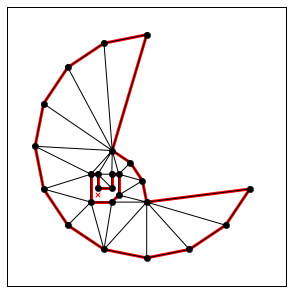

In [143]:
triangulated = triangulate({'vertices': caved_in_circle_with_complex_hole,
                            'segments': complex_segments,
                            'holes': [[2.25, 2.25]]}, 'pq0')

fig = plt.figure(num=6, figsize=(5, 5), dpi=30)
ax = fig.add_subplot(111)

tplot.plot(ax, **triangulated)

print('Num triangles: {}'.format(len(triangulated['triangles'])))

## Complex Hole (Conforming Delanuay)

Num triangles: 27


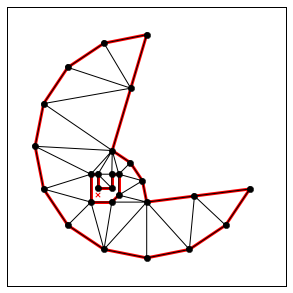

In [144]:
triangulated = triangulate({'vertices': caved_in_circle_with_complex_hole,
                            'segments': complex_segments,
                            'holes': [[2.25, 2.25]]}, 'pq0L')

fig = plt.figure(num=7, figsize=(5, 5), dpi=30)
ax = fig.add_subplot(111)

tplot.plot(ax, **triangulated)

print('Num triangles: {}'.format(len(triangulated['triangles'])))